# Probablistic Couterfactual Inference

Chapter nine of the book covers the general algorithm for doing probablistic counterfactual inferencing. The general algorithm consists of three steps:
1.   ***Abduction***
2.   ***Action***
3.   ***Prediction***

**Abduction** deals with *inferring the distribution of the exogenous variables given the factual conditions.*

**Action** deals with *implementing the hypothetical condition as an ideal intervention in the hypothetical world.*

**Prediction** deals with using the *distribution of the exogenous variables to derive the distributions of the hypothetical outcomes.*

Two case studies are used to illustrate the steps of this algorithm using the pyro library. The first one is modeling femur length as a cause of height. The second one deals with semantic editing of generated images.  



## Case Study One

In the first case study we want to model two questions we have regarding femur lengh causing height.

* The first question is a **conditional hypothetical** stated as follows: What would an individual’s height be if their femur length was 46 cm?

* The second question is a **parrallel-world counterfacutal** stated as follows:An individual’s femur is 44 cm, and their height is 165 cm. What would their height be if femur length was 46 cm?

The first question i.e., the **conditional hypothetical** has the following probability distribution: $P(H_{F=46})$; which equates to the probability distribution of a person's height when the *intervention* is done to set the random variable femur length to 46 cm.

The second question i.e., the **parrallel-world counterfacutal** has the following probability distribution: $P(H_{F=46}|F=44, H=165)$; which equates to the probability distribution of a person's height when the *intervention* is done to set the random variable femur length to 46 cm *when in fact the person's femur length is 44 and height is 165 cm.*

In addition to femur length being a cause of height we also add the random variable of sex as a cause of both femur length and height. Accordingly, the subsequent code and sections will implement the **conditional hypothetical** and the **parrallel-world counterfacutal** through **Abduction**, **Action**, and  **Prediction** after converting the Causal DAG (below) into a SCM






### Causal DAG: Conditional Hypothetical Example
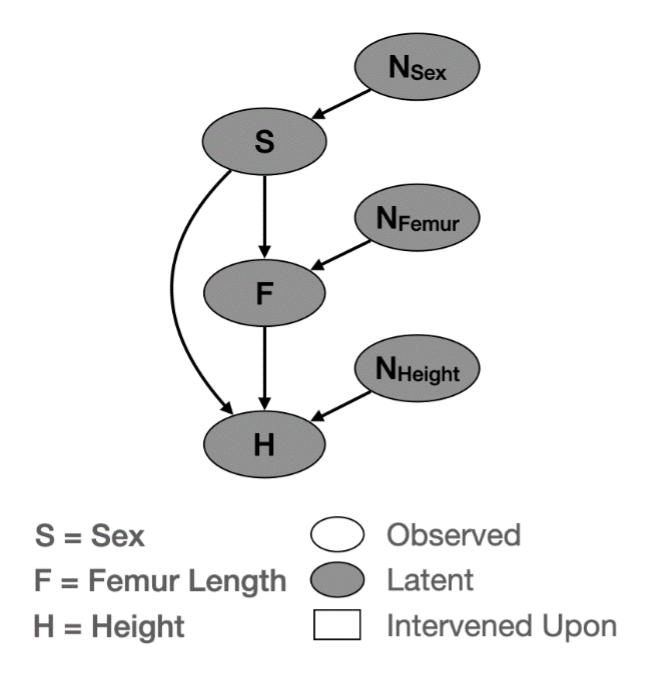


### SCM and Abduction: Conditional Hypothetical Example

As seen from the causal DAG the endogenous variables are Sex, Femur Length, and Height and the exogenous variables are $N_{Sex}$, $N_{Femur}$, $N_{Height}$. Under step 1 of **Abduction** we model the distribution of the exogenous variables given the factual conditions. In this case, the **conditional hypothetical's** probability distribution i.e., $P(H_{F=46})$ does not have factual conditions, so we can model them just using prior distributions. The only cavet here is that in order to use gradient based optimizations such as SGD, Adam, etc, we need to use a distribution/function that is **continuously differentiable** for the endogenous variables i.e., their assignment functions.

Because of this the book uses a pseudo-delta distribution in which a [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution) is transformed to approximate the [Dirac delta distribution](https://en.wikipedia.org/wiki/Dirac_delta_function); which is a debateable "function" that is zero everywhere except at zero!!!😆 This pseudo-delta distribution is used to model the assignment functions for the endogenous variables of Femur Length and Height.


In [ ]:
!pip install pyro-ppl

In [ ]:
from torch import tensor
from pyro.distributions import Bernoulli, Normal
from pyro import sample
from functools import partial

In [ ]:
# exogenous prior distributions
exogenous = {
    'N_sex': Bernoulli(.5),
    'N_femur': Normal(0., 1.),
    'N_height': Normal(0., 1.),
}

# pseudo dirac distribution
PseudoDelta = partial(Normal, scale=.01)

# assignment function: Sex
def f_sex(N_sex):
    return sample("sex", Bernoulli(N_sex))

# assignment function: Femur Length
def f_femur(sex, N_femur):
    if sex == tensor(1.0):
        μ = 43.7 + 2.3 * N_femur
    else:
        μ = 40.238 + 1.9 * N_femur
    return sample("femur", PseudoDelta(μ))

# assignment function: Height
def f_height(femur, sex, N_height):
    if sex == tensor(1.0):
        μ = 61.41 + 2.21 * femur + 7.62 * N_height
    else:
        μ = 54.1 + 2.47 * femur + 7 * N_height
    return sample("height", PseudoDelta(μ))

# SCM model
def model(exogenous):
    N_sex = sample("N_sex", exogenous['N_sex'])
    N_femur = sample("N_femur", exogenous['N_femur'])
    N_height = sample("N_height", exogenous['N_height'])
    sex = f_sex(N_sex)
    femur = f_femur(sex, N_femur)
    height = f_height(femur, sex, N_height)
    return sex, femur, height

### Action and Prediction: Conditional Hypothetical Example

In the **Action** step of probablistic counterfactual inference, *the hypothetical condition is implemented as the ideal intervention in the hypothetical world.* As detailed previously the **conditional hypothetical** has the following probability distribution: $P(H_{F=46})$. Since the distribution has no factual conditions, there is no need to model the hypothetical condition in a hypothetical/parrallel world. The intervention i.e., F=46 will be done using [pyro's do function](https://docs.pyro.ai/en/dev/_modules/pyro/primitives.html#sample) in which the above SCM model and the intervention i.e., F=46, will be passed to it.

Then in the **Prediction** step of probablistic counterfactual inference, the intervened model is repeatedly called using the prior distributions of the exogenous variables to generate/sample values for the endogenous variable Height. We will visualize the **conditional hypothetical** distribution i.e., $P(H_{F=46})$ as a histogram.

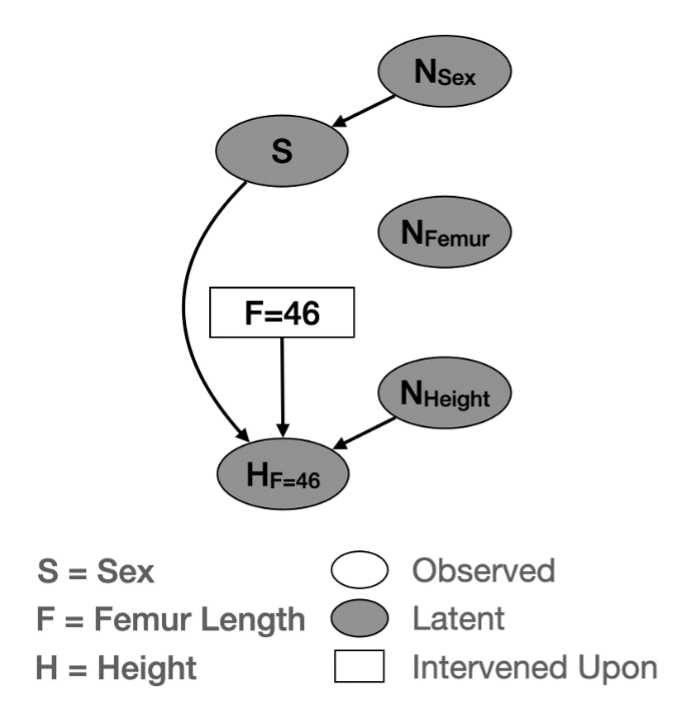

In [ ]:
import matplotlib.pyplot as plt
import pyro

# intervened model: Action step
int_model = pyro.do(model, data={"femur": tensor(46.0)})

# generated/sampled values: Prediction step
int_samples = []
for _ in range(10000):
    _, _, int_height = int_model(exogenous)
    int_samples.append(float(int_height))

# visualizing conditional hypothetical distribution
plt.hist(
    int_samples,
    bins=20,
    alpha=0.5,
    label="Intervention Samples",
    density=True
)
plt.ylim(0., .35)
plt.legend()
plt.xlabel("Height")
plt.show()

### SCM and Abduction: Parrallel-world Counterfacutal Example